🔍 Mencari parameter terbaik (ARIMA non-seasonal)...
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=908.241, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1020.086, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=917.521, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=978.559, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=906.738, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=954.568, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=904.814, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=906.275, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=904.729, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=906.251, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=907.618, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=897.832, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=901.542, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=899.671, Time=0.1

,Forecast
2025-11-24,488
2025-11-25,482
2025-11-26,463
2025-11-27,455
2025-11-28,448
2025-12-01,443


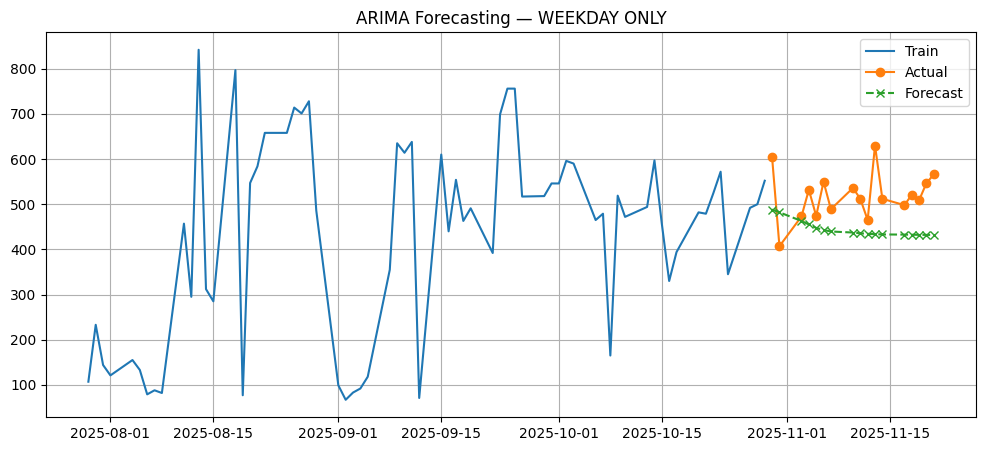

In [2]:
# ======================================================
# 📘 ARIMA Forecasting (Non-seasonal) — WEEKDAY ONLY
# ======================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
import math
import warnings
warnings.filterwarnings("ignore")

# ------------------------------------------------------
# 1. LOAD DATA
# ------------------------------------------------------
df = pd.read_excel("data_pengunjung_perpustakaan.xlsx")
df['Tanggal'] = pd.to_datetime(df['Tanggal'])
df = df.sort_values('Tanggal').set_index('Tanggal')

# ------------------------------------------------------
# 2. RESAMPLE & CLEAN
# ------------------------------------------------------
data_daily = df.resample("D").sum()

data_daily['Jumlah_Pengunjung'] = (
    data_daily['Jumlah_Pengunjung']
    .replace(0, np.nan)
    .fillna(method="ffill")
    .fillna(method="bfill")
).astype(int)

# ------------------------------------------------------
# 3. FILTER WEEKDAY ONLY (Mon–Fri)
# ------------------------------------------------------
weekday_data = data_daily[data_daily.index.dayofweek <= 4]

# ------------------------------------------------------
# 4. TRAIN / TEST SPLIT
# ------------------------------------------------------
train_size = int(len(weekday_data) * 0.8)
train = weekday_data.iloc[:train_size]
test = weekday_data.iloc[train_size:]

# ------------------------------------------------------
# 5. AUTO ARIMA (NO SEASONAL)
# ------------------------------------------------------
print("🔍 Mencari parameter terbaik (ARIMA non-seasonal)...")

model_auto = auto_arima(
    train['Jumlah_Pengunjung'],
    seasonal=False,      # <--- NON SEASONAL
    stepwise=True,
    trace=True,
    error_action="ignore",
    suppress_warnings=True
)

print("\n📌 Model terbaik:")
print(model_auto.summary())

# ------------------------------------------------------
# 6. FIT ARIMA
# ------------------------------------------------------
model = model_auto

# ------------------------------------------------------
# 7. FORECAST TEST SET
# ------------------------------------------------------
forecast = model.predict(n_periods=len(test))
forecast = pd.Series(forecast, index=test.index)

# RMSE & MAPE
rmse = math.sqrt(mean_squared_error(test['Jumlah_Pengunjung'], forecast))
mape = np.mean(np.abs((test['Jumlah_Pengunjung'] - forecast) / test['Jumlah_Pengunjung'])) * 100

print(f"\n📉 RMSE: {rmse:.3f}")
print(f"📈 MAPE: {mape:.2f}%")

# ------------------------------------------------------
# 8. FORECAST 6 HARI KERJA MULAI 24 NOV
# ------------------------------------------------------
start_date = pd.to_datetime("2025-11-24")

future_dates = []
d = start_date

while len(future_dates) < 6:
    if d.dayofweek <= 4:  # weekday only (Mon–Fri)
        future_dates.append(d)
    d += pd.Timedelta(days=1)

# ambil nilai forecast sebagai pure numpy array
forecast_values = model.predict(n_periods=6)
forecast_values = np.array(forecast_values, dtype=float)

forecast_table = pd.DataFrame({
    "Forecast": np.round(forecast_values).astype(int)
}, index=future_dates)

print("\n🔮 Forecast 6 Hari Kerja (mulai 24 Nov):")
display(forecast_table)

# ------------------------------------------------------
# 9. PLOT
# ------------------------------------------------------
plt.figure(figsize=(12,5))
plt.plot(train.index, train["Jumlah_Pengunjung"], label="Train")
plt.plot(test.index, test["Jumlah_Pengunjung"], label="Actual", marker="o")
plt.plot(test.index, forecast, label="Forecast", marker="x", linestyle="--")
plt.title("ARIMA Forecasting — WEEKDAY ONLY")
plt.grid(True)
plt.legend()
plt.show()
